# CQI Time-Series Forecasting

## Small Survey

- What is Channel Quality Indicator (CQI)?

Channel Quality Indicator (CQI) is a value that indicates the quality of a wireless channel. It is used by cellular networks to determine the best modulation and coding scheme for a particular transmission. The higher the CQI value, the better the quality of the channel.

- How does CQI work?

CQI is calculated by the user equipment (UE) based on the received signal strength and the error rate. The UE then sends the CQI value to the base station (BS). The BS uses the CQI value to determine the best modulation and coding scheme for the transmission.

- Why is CQI important?

CQI is important because it allows cellular networks to adapt to changes in the wireless channel. As the channel quality changes, the UE can send a new CQI value to the BS. This allows the BS to adjust the modulation and coding scheme accordingly.

- What are the different types of CQI?

There are two main types of CQI:
Absolute CQI: This is the most common type of CQI. It is a single value that indicates the overall quality of the channel.
Relative CQI: This type of CQI is used in some advanced cellular networks. It is a set of values that indicate the quality of the channel in different frequency bands.
How is CQI used?

- CQI is used by cellular networks to determine the following:

The best modulation and coding scheme for a particular transmission
The amount of power that should be used for a particular transmission
The probability of error for a particular transmission

## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


## Data Loading

In [7]:
df = pd.read_csv("./data/ue-lte-network-traffic-stats.csv")
df.head()

,UE1: web-rtc,UE1: sipp,UE1: web-server,UE2: web-rtc,UE2: sipp,UE2: web-server,UE3: web-rtc,UE3: sipp,UE3: web-server,UE1-Jitter,UE2-Jitter,UE3-Jitter,UE1-CQI,UE2-CQI,UE3-CQI
0,16360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026981,0.0,0.0,15.0,10.0,12.0
1,1905.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005916,0.0,0.0,13.0,12.0,15.0
2,20021.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015945,0.0,0.0,12.0,15.0,15.0
3,33617.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030872,0.0,0.0,11.0,14.0,15.0
4,50102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035999,0.0,0.0,15.0,14.0,14.0


## Pre-Processing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48600 entries, 0 to 48599
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UE1: web-rtc     48600 non-null  float64
 1   UE1: sipp        48600 non-null  float64
 2   UE1: web-server  48600 non-null  float64
 3   UE2: web-rtc     48600 non-null  float64
 4   UE2: sipp        48600 non-null  float64
 5   UE2: web-server  48600 non-null  float64
 6   UE3: web-rtc     48600 non-null  float64
 7   UE3: sipp        48600 non-null  float64
 8   UE3: web-server  48600 non-null  float64
 9   UE1-Jitter       48600 non-null  float64
 10  UE2-Jitter       48600 non-null  float64
 11  UE3-Jitter       48600 non-null  float64
 12  UE1-CQI          48600 non-null  float64
 13  UE2-CQI          48600 non-null  float64
 14  UE3-CQI          48600 non-null  float64
dtypes: float64(15)
memory usage: 5.6 MB


In [9]:
df.shape

(48600, 15)

In [10]:
daily_TS = []

In [11]:
day_samples = 3600
for i in range(day_samples, df.shape[0],day_samples):
    daily_TS.append(df[i-day_samples: i])

In [12]:
for d in daily_TS:
    print(d.shape)

(3600, 15)
(3600, 15)
(3600, 15)
(3600, 15)
(3600, 15)
(3600, 15)
(3600, 15)
(3600, 15)
(3600, 15)
(3600, 15)
(3600, 15)
(3600, 15)
(3600, 15)


In [13]:
len(daily_TS)

13

In [14]:
#reindexing
for i in range(len(daily_TS)):
    daily_TS[i] = daily_TS[i].reset_index()

In [15]:
daily_TS[1]

,index,UE1: web-rtc,UE1: sipp,UE1: web-server,UE2: web-rtc,UE2: sipp,UE2: web-server,UE3: web-rtc,UE3: sipp,UE3: web-server,UE1-Jitter,UE2-Jitter,UE3-Jitter,UE1-CQI,UE2-CQI,UE3-CQI
0,3600,9249.0,0.0,0.0,0.0,17803.0,0.0,0.0,0.0,0.0,0.008380,0.015369,0.0000,5.0,7.0,15.0
1,3601,9758.0,0.0,0.0,0.0,30818.0,0.0,0.0,0.0,0.0,0.020158,0.007954,0.0000,5.0,8.0,13.0
2,3602,20638.0,0.0,0.0,0.0,26067.0,0.0,0.0,0.0,0.0,0.015436,0.023392,0.0000,15.0,3.0,12.0
3,3603,32920.0,0.0,0.0,0.0,21358.0,0.0,0.0,0.0,0.0,0.027082,0.015842,0.0000,11.0,10.0,15.0
4,3604,16864.0,0.0,0.0,0.0,23056.0,0.0,0.0,0.0,0.0,0.022839,0.018144,0.0000,7.0,11.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,7195,28557.0,0.0,0.0,0.0,29907.0,0.0,0.0,0.0,0.0,0.037887,0.006507,0.0000,14.0,10.0,15.0
3596,7196,30264.0,0.0,0.0,0.0,18979.0,0.0,0.0,0.0,0.0,0.034205,0.020819,0.0000,7.0,8.0,15.0
3597,7197,21832.0,0.0,0.0,0.0,36895.0,0.0,0.0,0.0,0.0,0.037409,0.022285,0.0000,7.0,12.0,15.0
3598,7198,9077.0,0.0,0.0,0.0,23500.0,0.0,0.0,0.0,0.0,0.026559,0.015060,0.0000,7.0,13.0,15.0


## Exploratory Analysis

### Correlation

In [16]:
df.corr()

,UE1: web-rtc,UE1: sipp,UE1: web-server,UE2: web-rtc,UE2: sipp,UE2: web-server,UE3: web-rtc,UE3: sipp,UE3: web-server,UE1-Jitter,UE2-Jitter,UE3-Jitter,UE1-CQI,UE2-CQI,UE3-CQI
UE1: web-rtc,1.000000,NaN,-0.328186,-0.433476,0.418185,NaN,-0.265253,NaN,-0.242626,0.435580,-0.141789,-0.403526,0.073775,0.011858,0.190266
UE1: sipp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UE1: web-server,-0.328186,NaN,1.000000,0.273150,-0.021553,NaN,0.223742,NaN,0.134811,0.056765,0.140956,0.405971,-0.109060,-0.037797,-0.166680
UE2: web-rtc,-0.433476,NaN,0.273150,1.000000,-0.478422,NaN,-0.211203,NaN,0.655387,-0.359907,0.171695,0.390997,0.020301,0.124215,-0.216581
UE2: sipp,0.418185,NaN,-0.021553,-0.478422,1.000000,NaN,-0.008879,NaN,-0.339125,0.403580,0.224457,-0.213448,-0.314453,-0.310012,0.214926
UE2: web-server,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UE3: web-rtc,-0.265253,NaN,0.223742,-0.211203,-0.008879,NaN,1.000000,NaN,-0.117554,-0.182754,-0.060474,0.456847,-0.291159,-0.277392,0.099607
UE3: sipp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UE3: web-server,-0.242626,NaN,0.134811,0.655387,-0.339125,NaN,-0.117554,NaN,1.000000,-0.258048,0.121240,0.558302,-0.023013,0.037502,-0.105065
UE1-Jitter,0.435580,NaN,0.056765,-0.359907,0.403580,NaN,-0.182754,NaN,-0.258048,1.000000,-0.142989,-0.282704,-0.006947,-0.048685,0.106817


<AxesSubplot:>

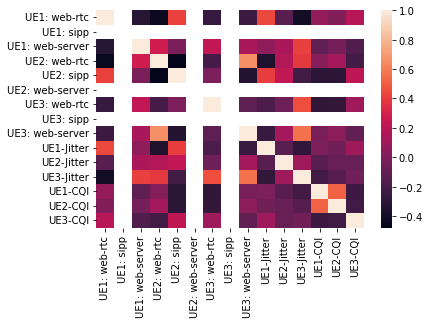

In [17]:
sns.heatmap(df.corr())

### Focusing on CQI

In [18]:
daily_CQI_TS = []
columns = ["UE1-CQI", "UE2-CQI", "UE3-CQI"]

for i in range(len(daily_TS)):
    daily_CQI_TS.append(daily_TS[i][columns])

In [19]:
daily_CQI_TS[0]

,UE1-CQI,UE2-CQI,UE3-CQI
0,15.0,10.0,12.0
1,13.0,12.0,15.0
2,12.0,15.0,15.0
3,11.0,14.0,15.0
4,15.0,14.0,14.0
...,...,...,...
3595,13.0,15.0,14.0
3596,15.0,9.0,11.0
3597,11.0,12.0,15.0
3598,9.0,10.0,10.0


### Statistics

In [20]:
df[columns].describe()

,UE1-CQI,UE2-CQI,UE3-CQI
count,48600.000000,48600.000000,48600.000000
mean,9.570782,11.441399,13.283868
std,3.420918,2.909377,2.364019
min,0.000000,0.000000,0.000000
25%,7.000000,9.000000,12.000000
50%,10.000000,12.000000,14.000000
75%,12.000000,14.000000,15.000000
max,15.000000,15.000000,15.000000


#### Daily Mean and Standard Deviation

In [21]:
means = []
stds = []

for ts in daily_CQI_TS:
  means.append(ts.mean())
  stds.append(ts.std())

In [22]:
means_per_day = {}
stds_per_day = {}

for col in columns:
  mm = []
  ss = []
  for i in range(len(means)):
    mm.append(means[i][col])
    ss.append(stds[i][col])

  means_per_day[col] = mm
  stds_per_day[col] = ss

In [23]:
days = [i for i in range(1,14)]

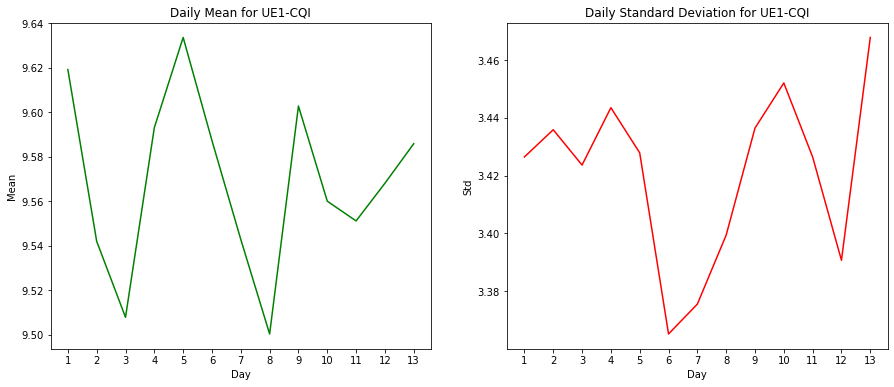

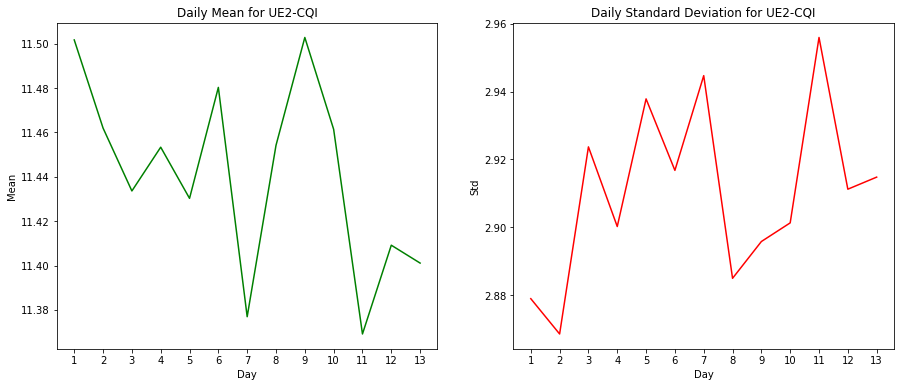

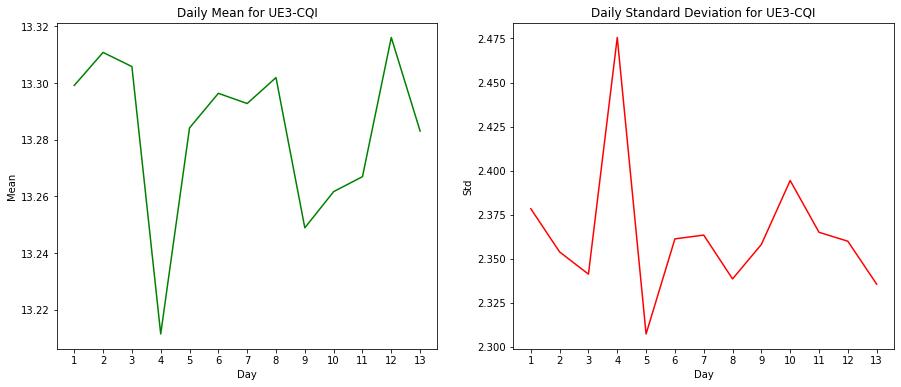

In [24]:
for col in columns:
  fig, ax = plt.subplots(1,2, figsize=(15,6))
  ax[0].plot(days, means_per_day[col], color="green")
  ax[0].set_xlabel("Day")
  ax[0].set_ylabel("Mean")
  ax[0].set_xticks(days)
  ax[0].set_title(f"Daily Mean for {col}")

  ax[1].plot(days, stds_per_day[col], color="red")
  ax[1].set_xlabel("Day")
  ax[1].set_ylabel("Std")
  ax[1].set_xticks(days)
  ax[1].set_title(f"Daily Standard Deviation for {col}")

### ACF & PCF

##### ACF

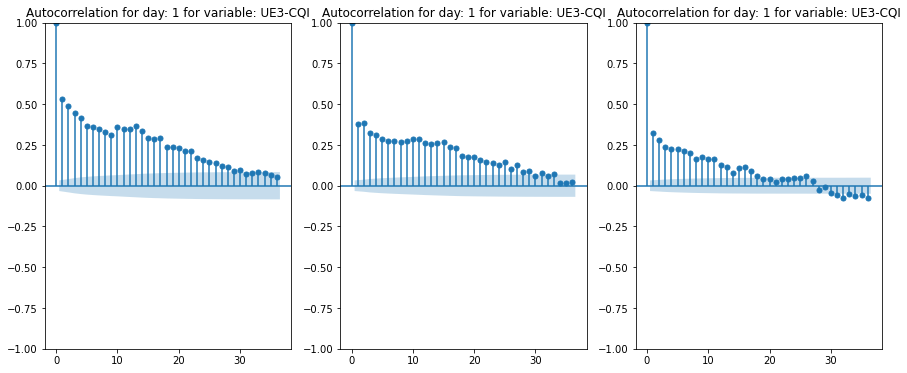

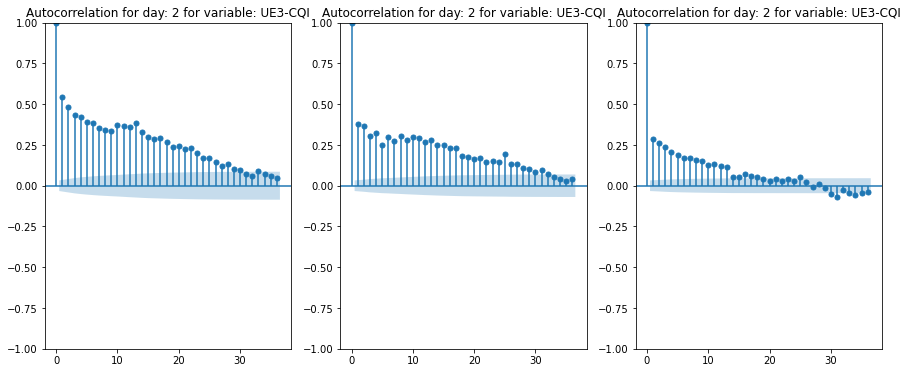

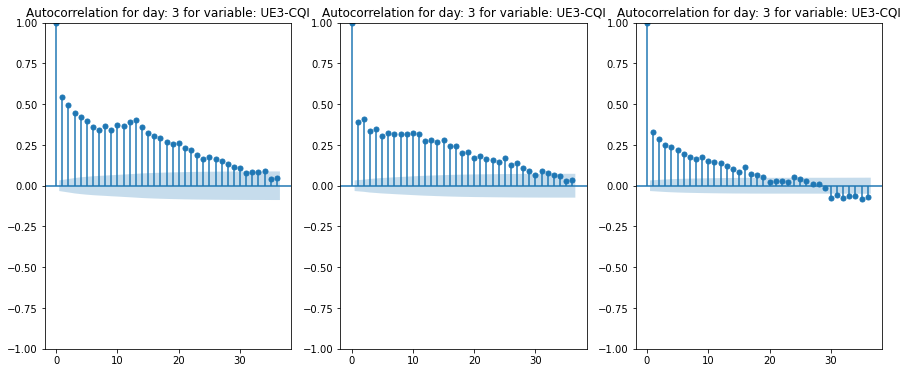

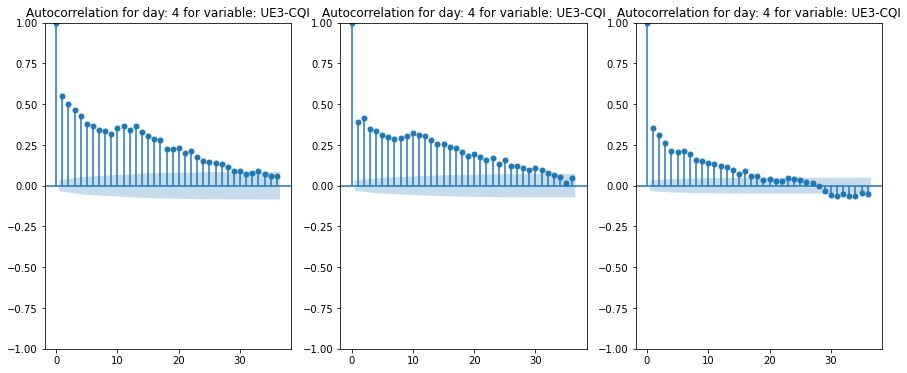

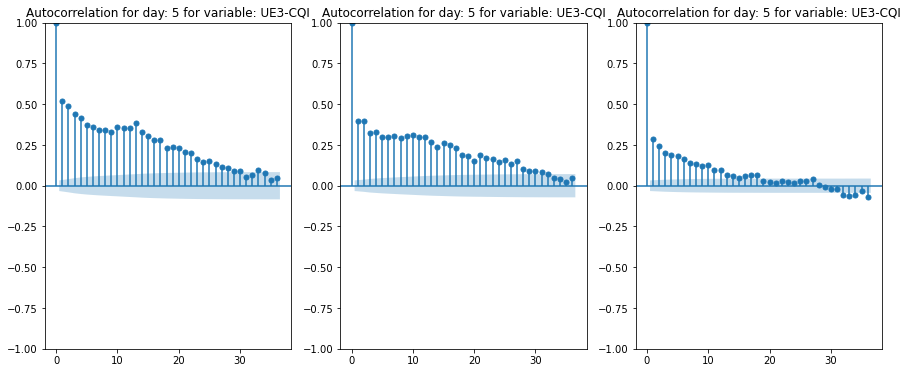

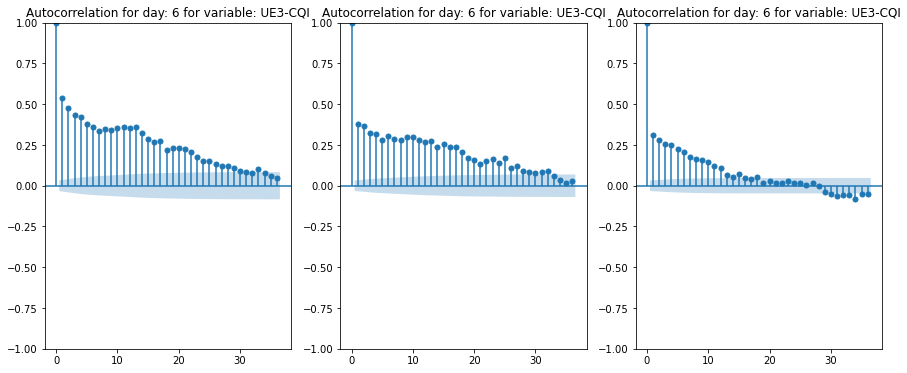

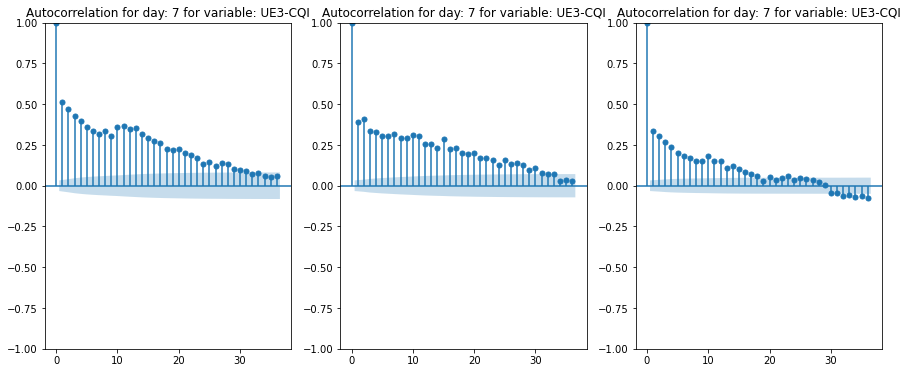

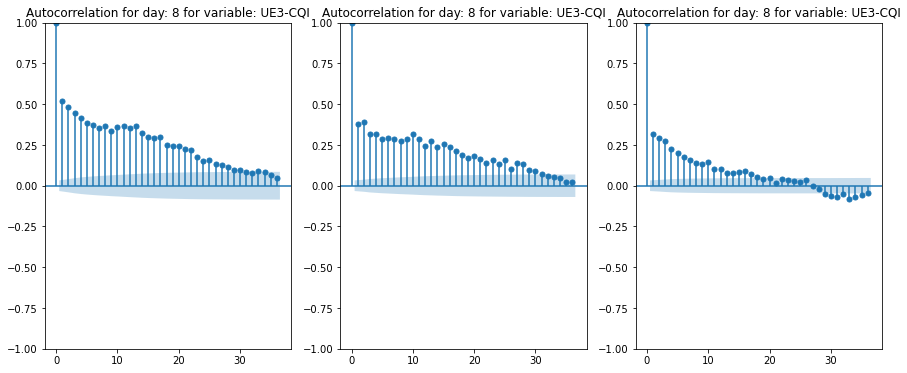

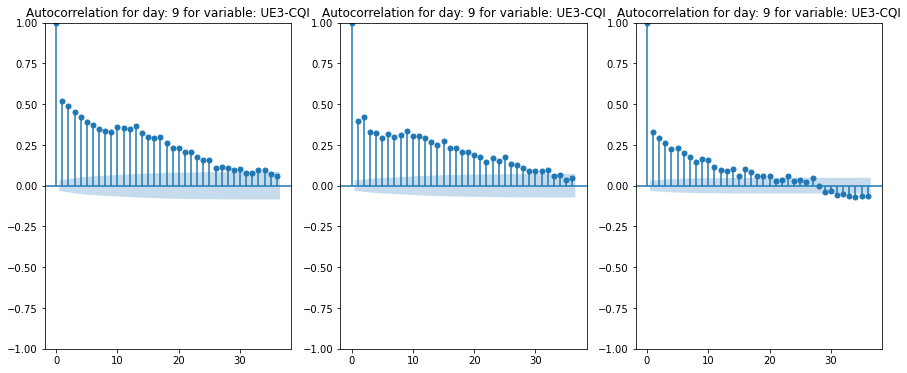

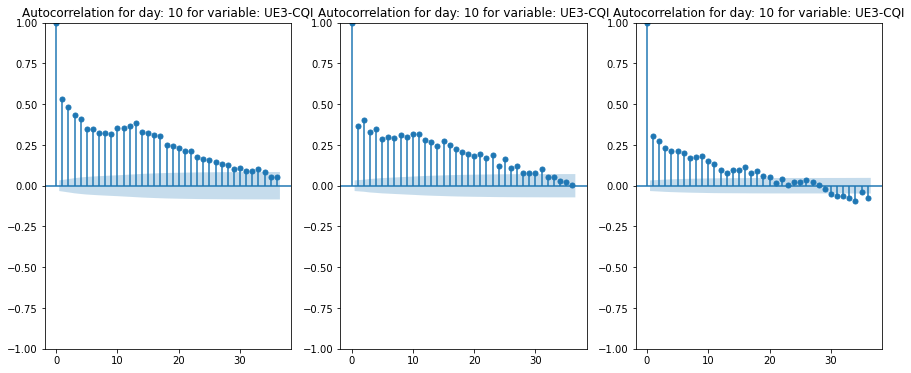

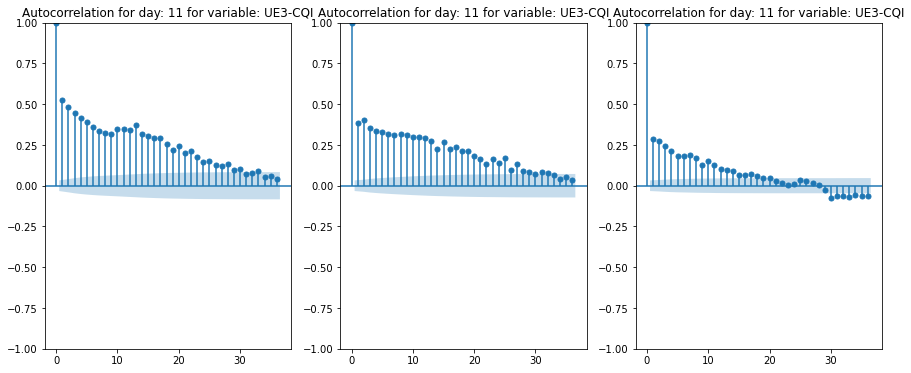

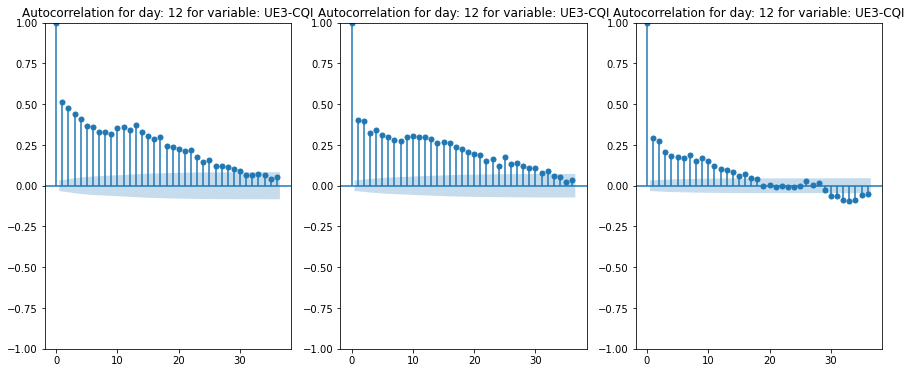

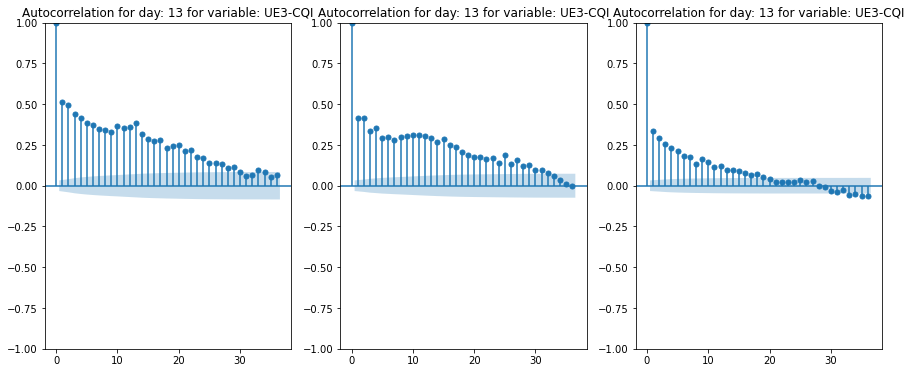

In [25]:
for i in range(13):
  fig, ax = plt.subplots(1,3, figsize=(15,6))
  for j in range(len(columns)):
    plot_acf(daily_CQI_TS[i][columns[j]],ax = ax[j],title=f'Autocorrelation for day: {i+1} for variable: {col}');

##### PACF

/home/ozi/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/ozi/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/ozi/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/ozi/anaconda3/lib/python3.9/sit

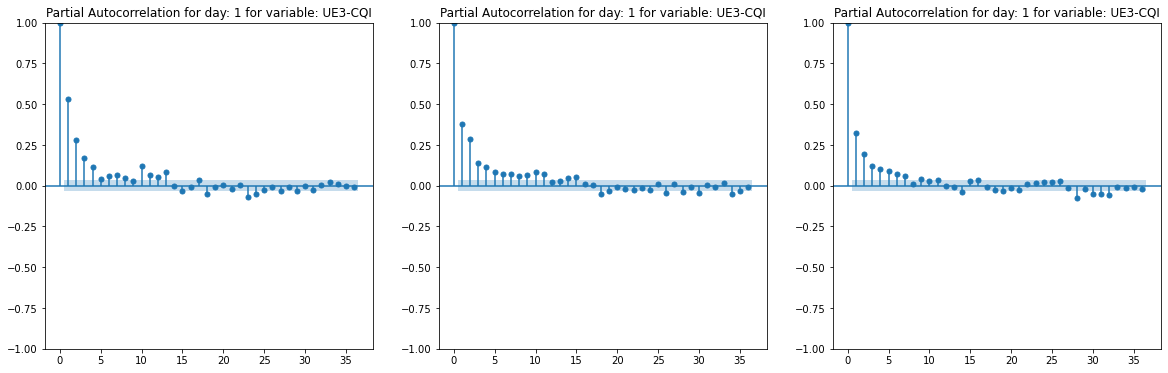

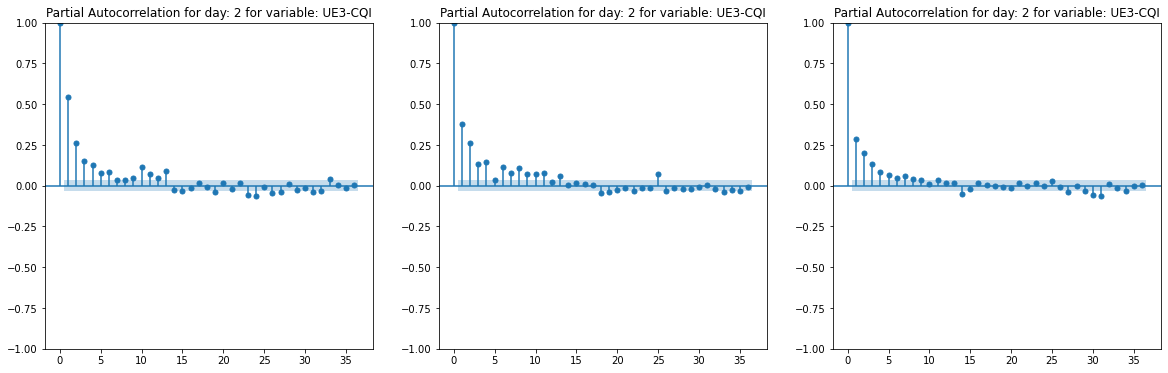

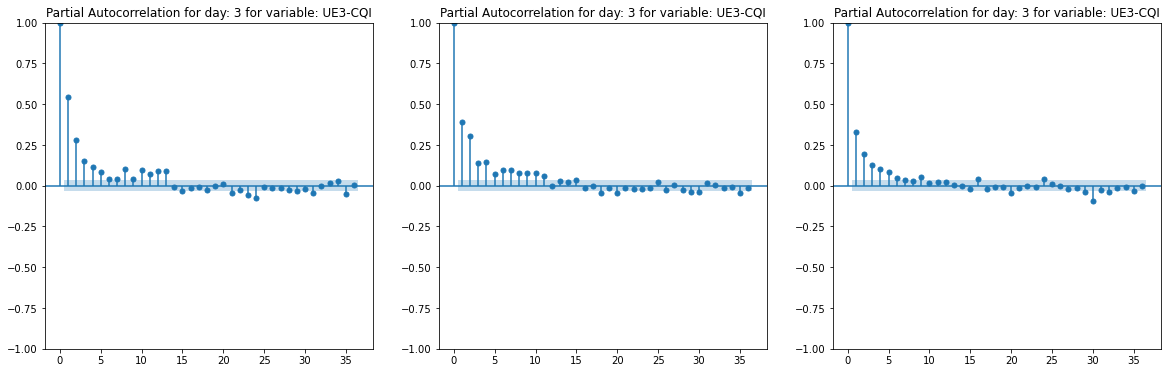

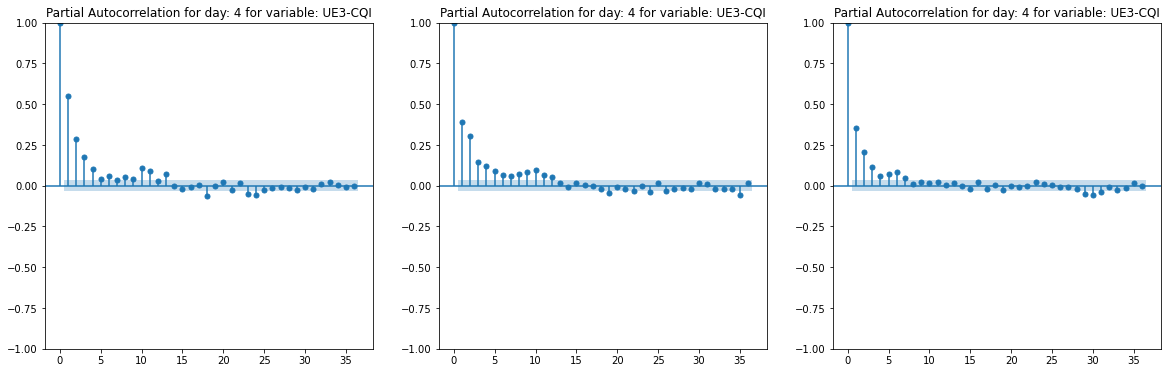

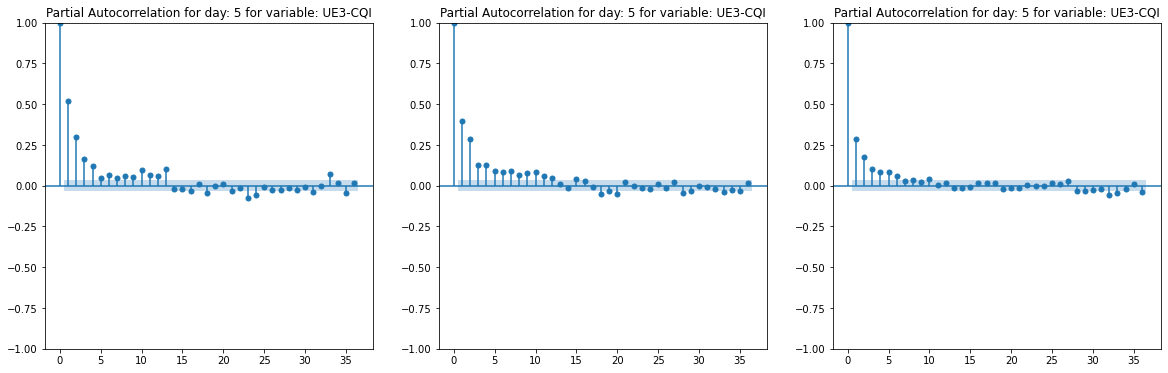

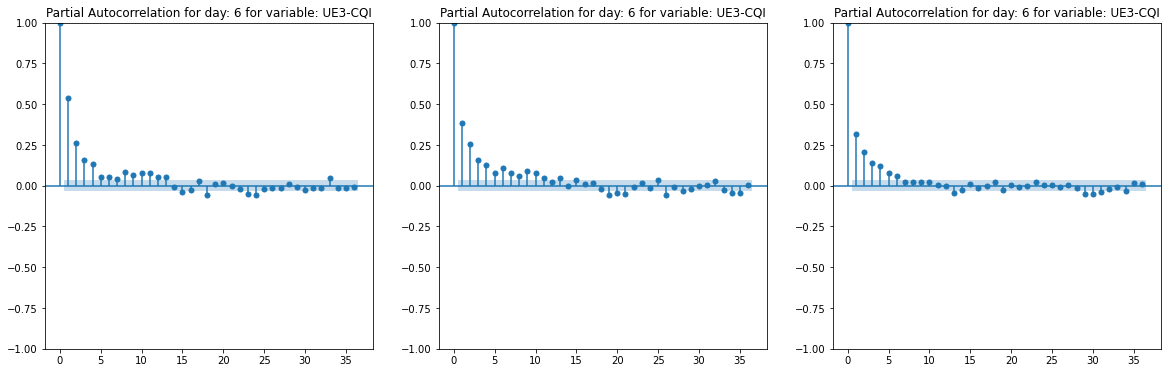

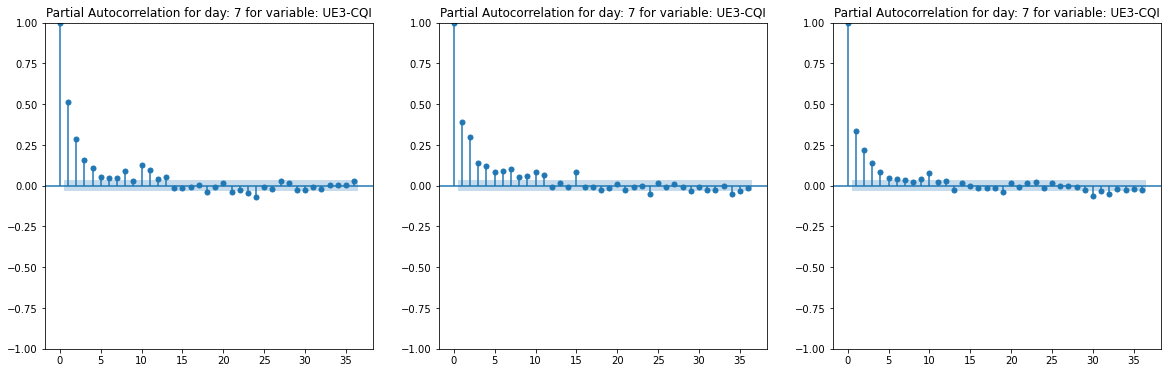

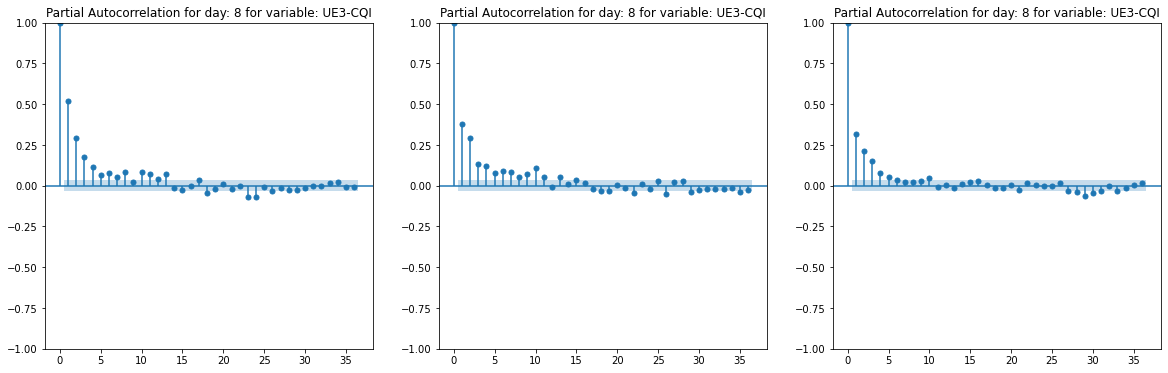

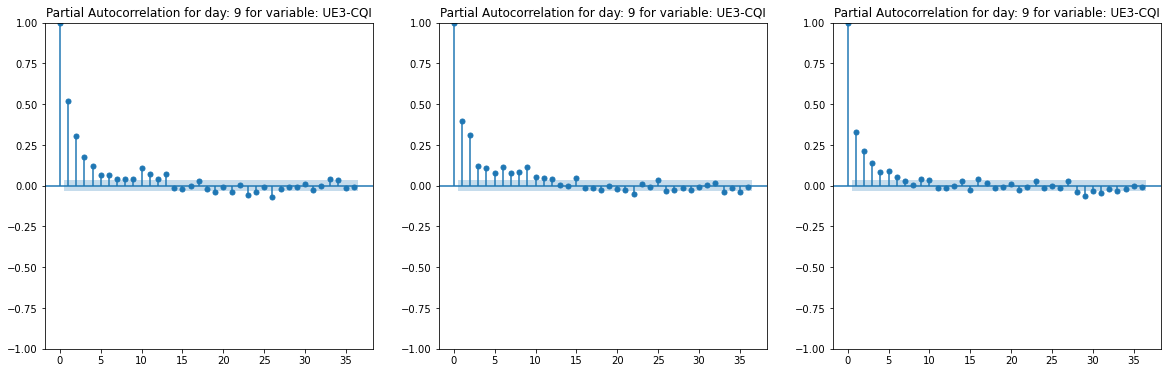

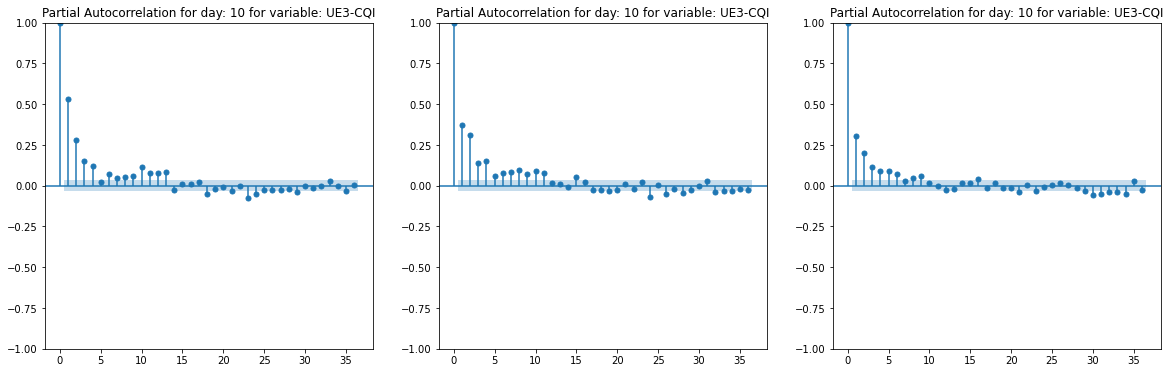

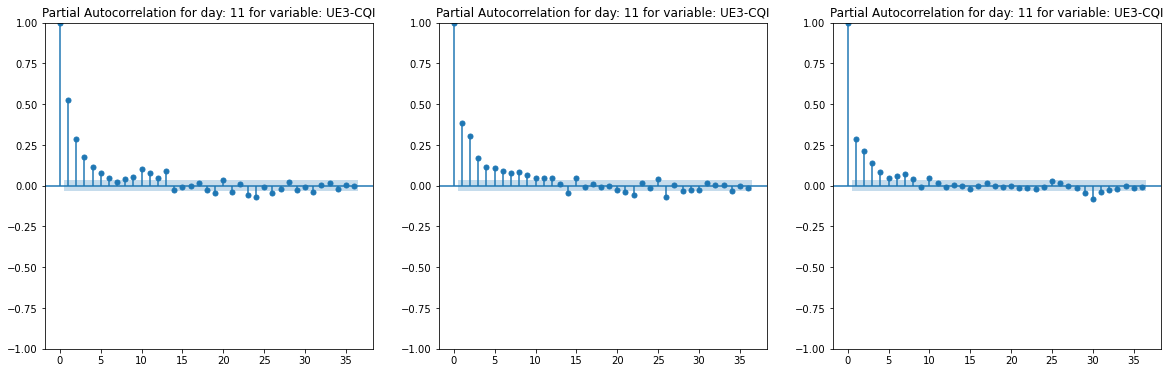

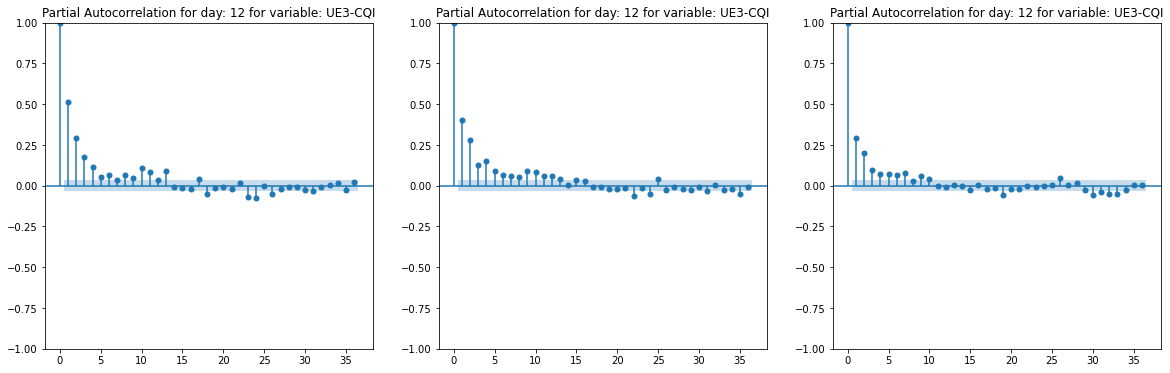

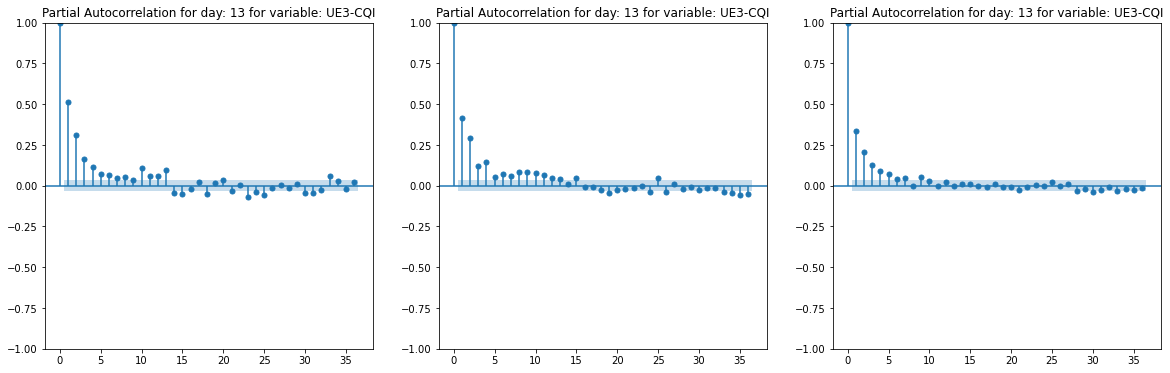

In [26]:
for i in range(13):
  fig, ax = plt.subplots(1,3, figsize=(20,6))
  for j in range(len(columns)):
    plot_pacf(daily_CQI_TS[i][columns[j]],ax = ax[j],title=f'Partial Autocorrelation for day: {i+1} for variable: {col}');

### Seasonlity, trend and residuals 

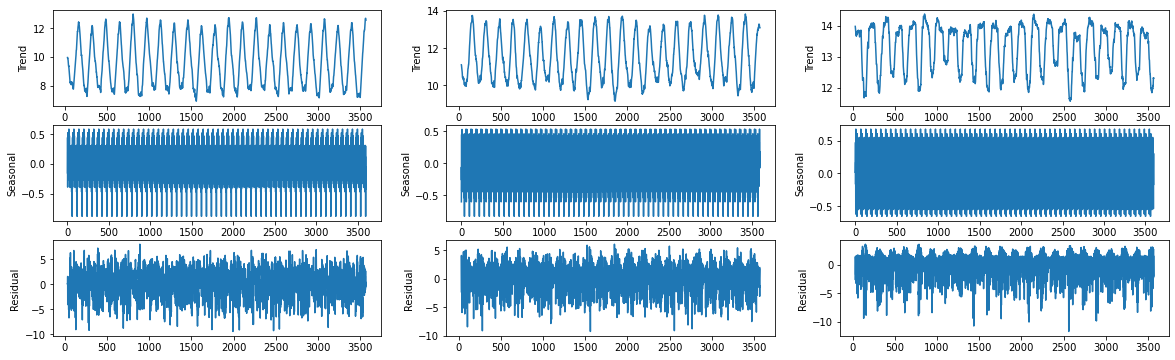

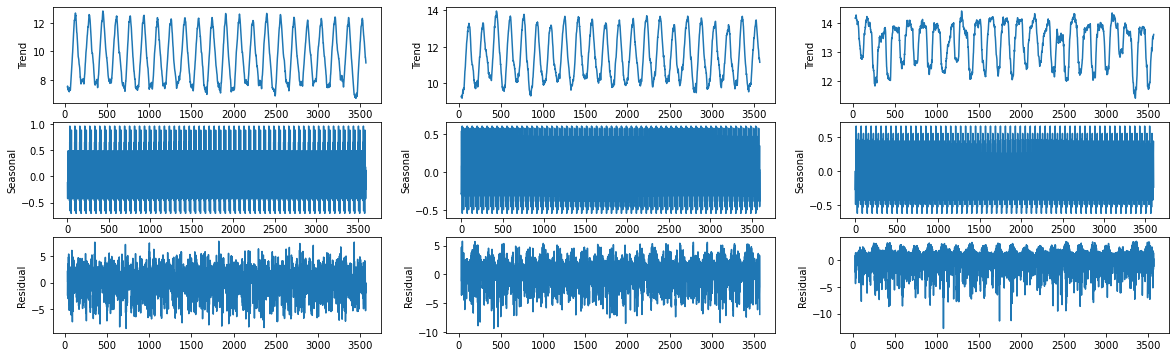

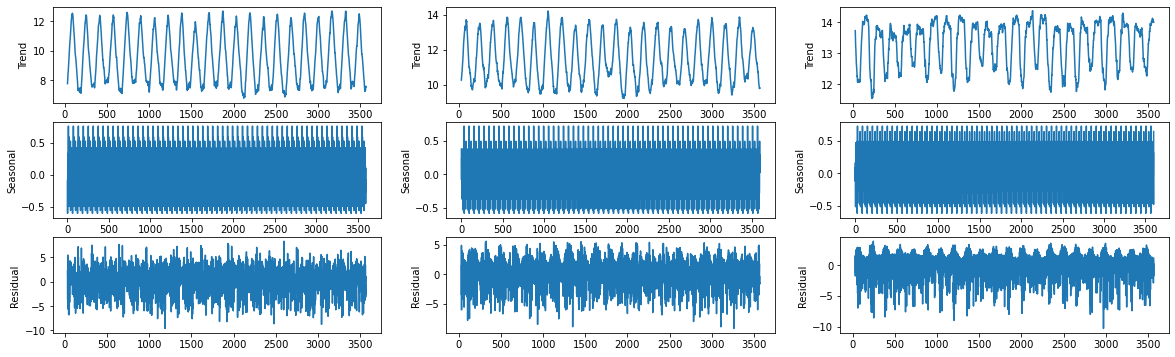

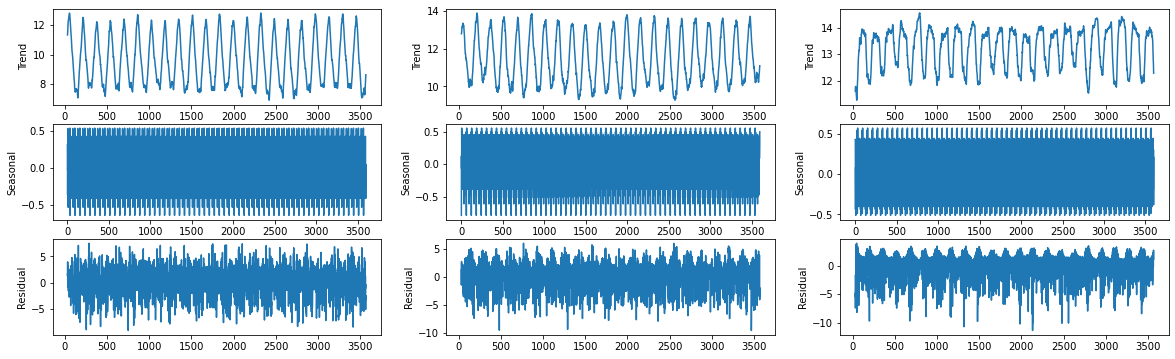

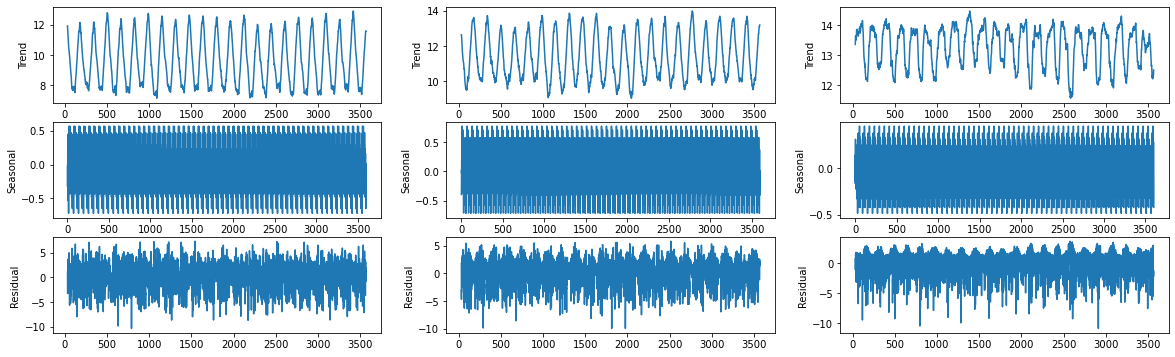

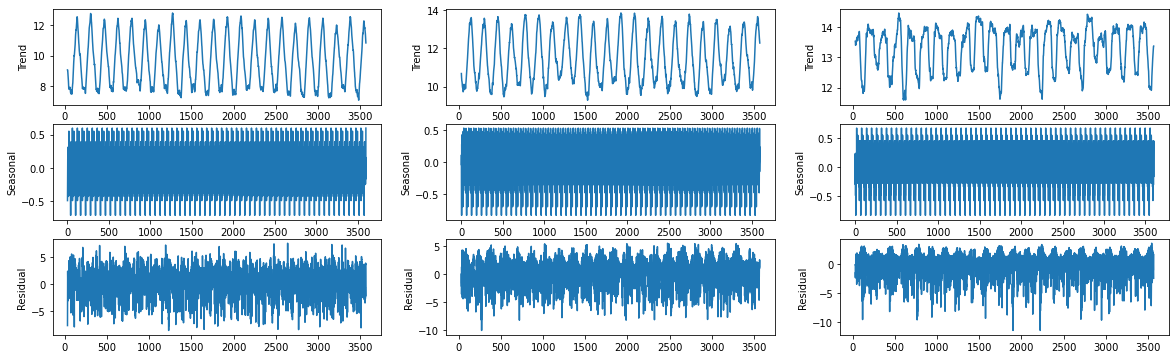

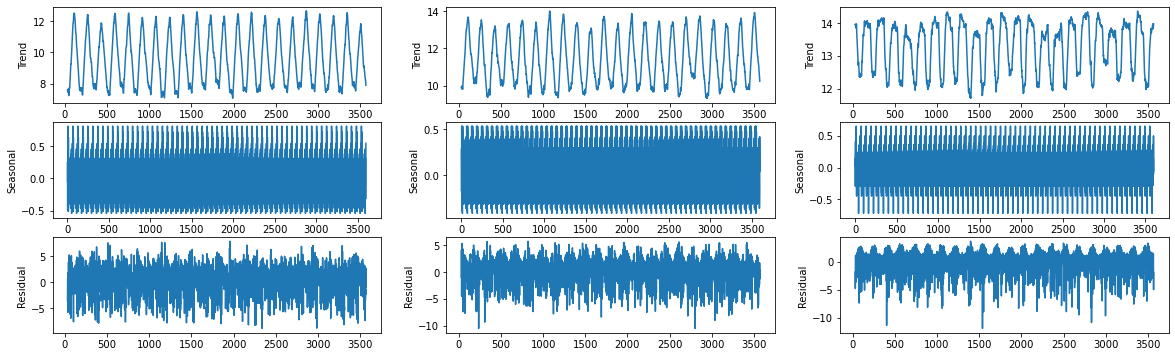

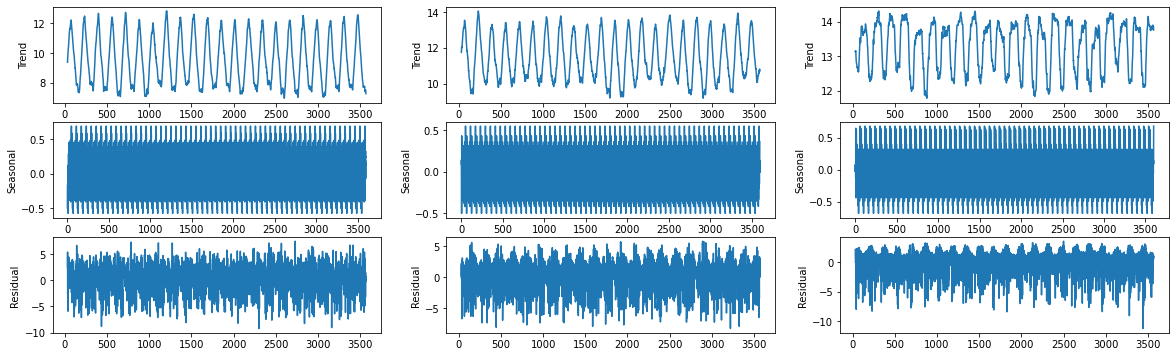

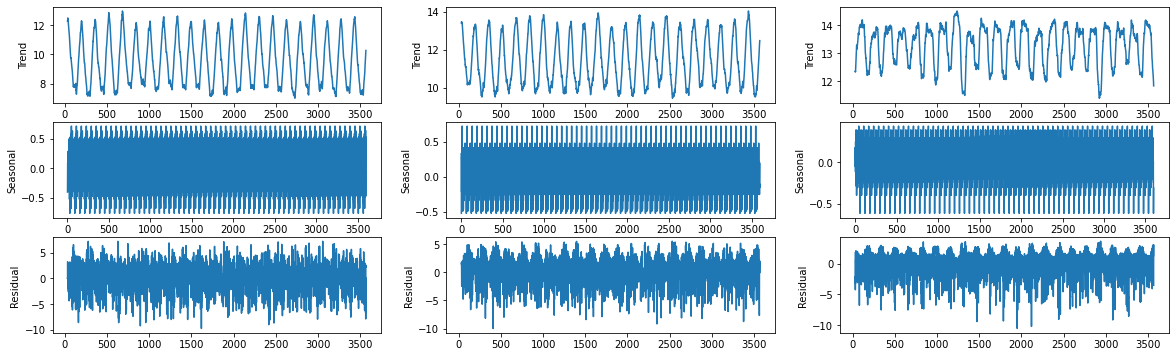

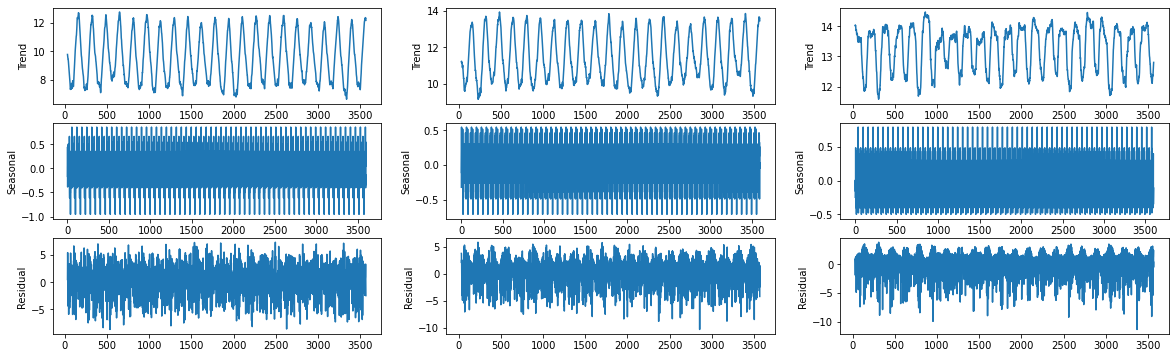

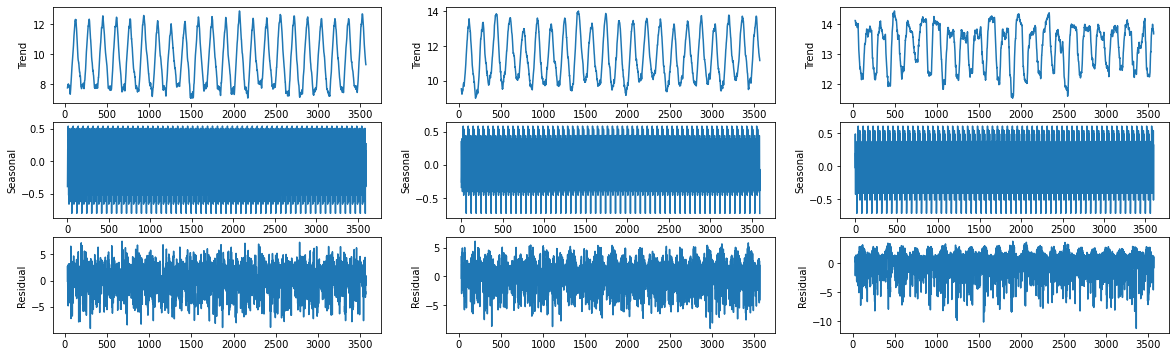

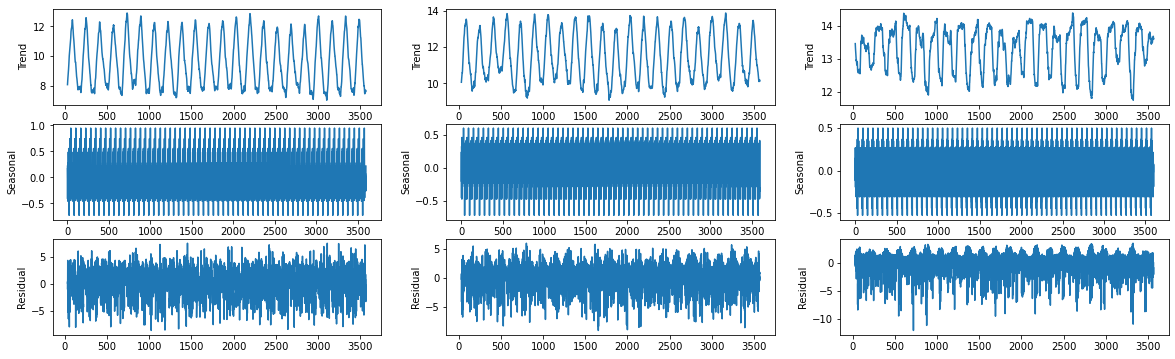

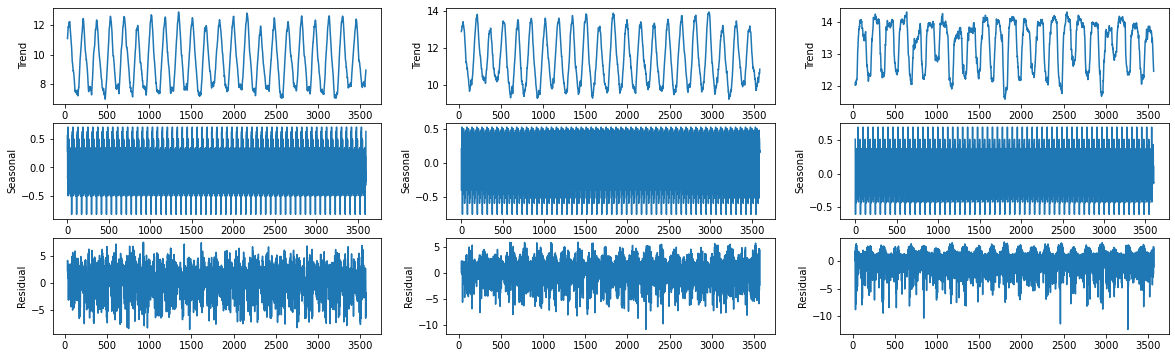

In [27]:
for i in range(13):
  fig, ax = plt.subplots(3,3, figsize=(20,6))
  
  for j in range(len(columns)):
    result = seasonal_decompose(daily_CQI_TS[i][columns[j]], period=60);
    result.trend.plot(ax=ax[0][j]);
    ax[0][j].set_ylabel('Trend')
    result.seasonal.plot(ax=ax[1][j]);
    ax[1][j].set_ylabel('Seasonal')
    result.resid.plot(ax=ax[2][j]);
    ax[2][j].set_ylabel('Residual')



In [28]:
result.seasonal

0       0.515975
1       0.074732
2       0.158912
3      -0.605636
4      -0.182754
          ...   
3595    0.012726
3596   -0.140523
3597   -0.124703
3598   -0.142641
3599    0.110466
Name: seasonal, Length: 3600, dtype: float64

### Stationarity Test

In [29]:
def stationarity_test(ts, columns):
  result = {}
  for col in columns:
    my_ts = ts[col]
    r = adfuller(my_ts)
    result[col] = (r[1] < 0.05)
  return result

In [30]:
stationarity_results = []

In [31]:
for ts in daily_CQI_TS:
  stationarity_results.append(stationarity_test(ts, ts.columns))

In [32]:
for i in range(len(stationarity_results)):
  print(f"Day {i}:")
  for col in columns:
    r = stationarity_results[i][col]
    if not r:
      print(f"{col}: {r}")

Day 0:
Day 1:
Day 2:
Day 3:
Day 4:
Day 5:
Day 6:
Day 7:
Day 8:
Day 9:
Day 10:
Day 11:
Day 12:


## Modeling

In [33]:
MSEs = {}
MAEs = {}

In [34]:
def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)

### Train/test split

In [35]:
day1 = daily_CQI_TS[0]
day1

,UE1-CQI,UE2-CQI,UE3-CQI
0,15.0,10.0,12.0
1,13.0,12.0,15.0
2,12.0,15.0,15.0
3,11.0,14.0,15.0
4,15.0,14.0,14.0
...,...,...,...
3595,13.0,15.0,14.0
3596,15.0,9.0,11.0
3597,11.0,12.0,15.0
3598,9.0,10.0,10.0


In [36]:
train_size = int(0.8*len(day1))
test_size = int(0.2*len(day1))

In [37]:
train = day1[:train_size]
test = day1[train_size:]

Text(0.5, 1.0, 'Training Data Day 1')

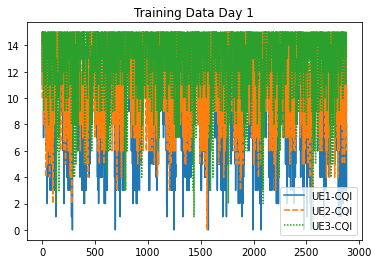

In [38]:
sns.lineplot(data=train).set_title("Training Data Day 1")

Text(0.5, 1.0, 'Training Data Day 1')

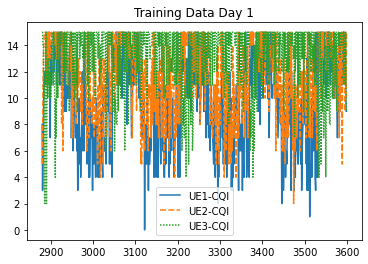

In [39]:
sns.lineplot(data=test).set_title("Training Data Day 1")

In [53]:
UEs_train = {}
UEs_test = {}
UEs_series = {}

In [54]:
time = np.arange(0, len(day1), step=1)

In [55]:
time_train = time[:train_size]
time_test = time[train_size:]

In [56]:
for col in train.columns:
    
    UEs_train[col] = np.array(train[col])
    UEs_test[col] = np.array(test[col])
    UEs_series[col] = np.array(day1[col])

### Naive Approach - baseline

In [44]:
def naive(train, test):
    y_hat = np.zeros(test.shape)
    y_hat[0] = train[-1]
    y_hat[1:] = test[:-1]

    return y_hat

In [45]:
UEs_y_hat = {}

for col in train.columns:
    UEs_y_hat[col] = naive(UEs_train[col], UEs_test[col])

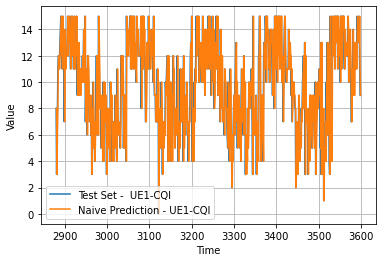

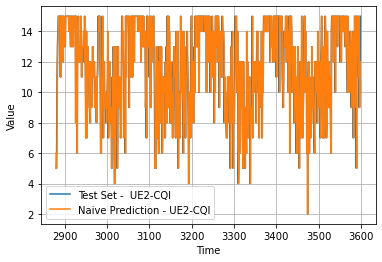

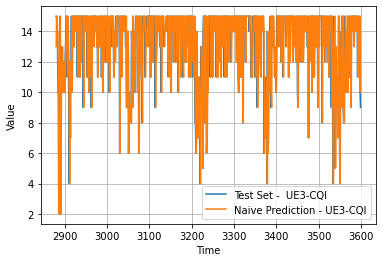

In [46]:
for col in train.columns:
    plt.title(f"{col} Test/Forecast")
    plot_series(time_test, UEs_test[col], label=f"Test Set -  {col}")
    plot_series(time_test, UEs_y_hat[col], label=f"Naive Prediction - {col}")
    plt.show()

In [49]:
MSEs["Naive"] = {}
MAEs["Naive"] = {}

for col in train.columns:
    
    MSEs["Naive"][col] = MSE(UEs_test[col], UEs_y_hat[col])
    MAEs["Naive"][col] = MAE(UEs_test[col], UEs_y_hat[col])
    print(col,":")
    print(f"MSE: {MSEs['Naive'][col]} | MAE: {MAEs['Naive'][col]}")
    


UE1-CQI :
MSE: 10.2875 | MAE: 2.4569444444444444
UE2-CQI :
MSE: 9.6375 | MAE: 2.326388888888889
UE3-CQI :
MSE: 8.069444444444445 | MAE: 1.961111111111111


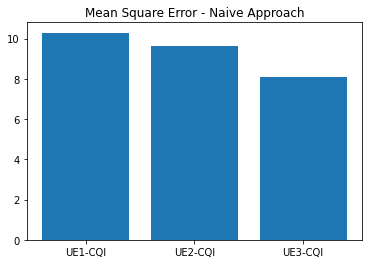

In [66]:
plt.title(f"Mean Square Error - Naive Approach")
plt.bar(range(len(MSEs["Naive"])), list(MSEs["Naive"].values()), tick_label=list(MSEs["Naive"].keys()))
plt.show()

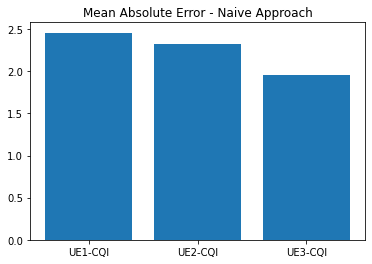

In [69]:
plt.title(f"Mean Absolute Error - Naive Approach")
plt.bar(range(len(MSEs["Naive"])), list(MAEs["Naive"].values()), tick_label=list(MAEs["Naive"].keys()))
plt.show()

### Moving Average

In [59]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast"""
    
    forecast = []
    
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
        
    # Conver to a numpy array
    np_forecast = np.array(forecast)
        
    return np_forecast

Creating Moving average with window equal to half minute - 30 sec

In [94]:
UEs_y_hat = {}
window_size = 30

In [95]:
for col in train.columns:
    moving_avg = moving_average_forecast(UEs_series[col], window_size=window_size)
    UEs_y_hat[col] = moving_avg[train_size-window_size:]

    

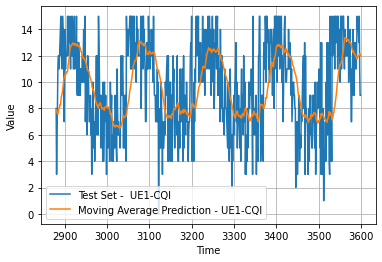

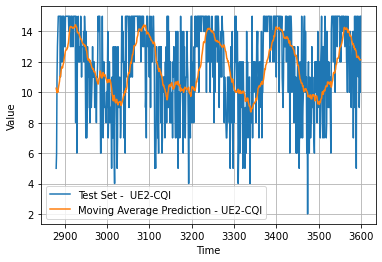

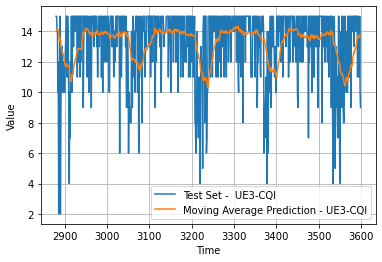

In [96]:
for col in train.columns:
    plt.title(f"{col} Test/Forecast")
    plot_series(time_test, UEs_test[col], label=f"Test Set -  {col}")
    plot_series(time_test, UEs_y_hat[col], label=f"Moving Average Prediction - {col}")
    plt.show()

In [97]:
MSEs["MA"] = {}
MAEs["MA"] = {}

for col in train.columns:
    
    MSEs["MA"][col] = MSE(UEs_test[col], UEs_y_hat[col])
    MAEs["MA"][col] = MAE(UEs_test[col], UEs_y_hat[col])
    print(col,":")
    print(f"MSE: {MSEs['MA'][col]} | MAE: {MAEs['MA'][col]}")

UE1-CQI :
MSE: 8.762533950617286 | MAE: 2.4006481481481483
UE2-CQI :
MSE: 7.2094953703703695 | MAE: 2.142361111111111
UE3-CQI :
MSE: 5.847049382716049 | MAE: 1.838611111111111


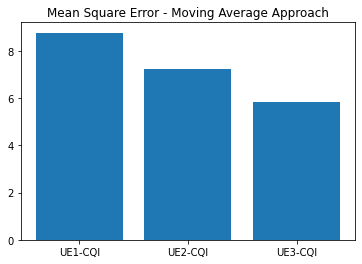

In [98]:
plt.title(f"Mean Square Error - Moving Average Approach")
plt.bar(range(len(MSEs["MA"])), list(MSEs["MA"].values()), tick_label=list(MSEs["MA"].keys()))
plt.show()

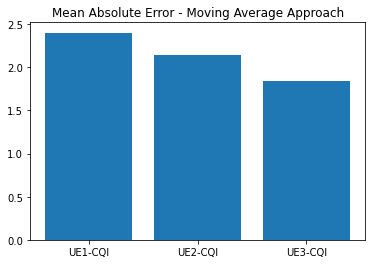

In [99]:
plt.title(f"Mean Absolute Error - Moving Average Approach")
plt.bar(range(len(MSEs["MA"])), list(MAEs["MA"].values()), tick_label=list(MAEs["MA"].keys()))
plt.show()

In [100]:
MSE_pd = pd.DataFrame(MSEs)
MAEs_pd = pd.DataFrame(MAEs)  

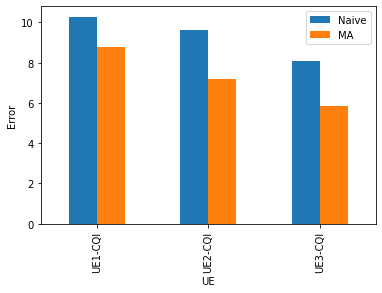

In [103]:
MSE_pd.plot(kind='bar');
plt.ylabel("Error");
plt.xlabel("UE");

### SARIMA

#### Picking Optimial Orders

#### Training

#### Testing

### LSTM